In [1]:
import csv
import numpy as np
import ROOT
%jsroot on

from matplotlib import pyplot
%matplotlib inline

Welcome to JupyROOT 6.07/07


# Getting Kaggle Higgs Machine Learning Data

The data has three categories of entries: Derived variables (those that have a physics meaning), principle variables (those that are used to create the derived variables), and event info comprised of event weights, and classification (signal or background).

In [2]:
inputfile = 'input/training.csv'
all = list(csv.reader(open(inputfile,"rb"), delimiter=','))
headers = all[0]
print 'using the derived variables:',headers[1:14]

print ''

print 'or the principle variables:',headers[14:-2]

print ''

print 'with weights and classification at:',headers[-2:]

using the derived variables: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality']

or the principle variables: ['PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

with weights and classification at: ['Weight', 'Label']


In this example I choose to look at the MMC mass since it gives the best separation of signal and background. 

I also scale the signal by 50 such that it is visible in the plots.

In [3]:
all = list(csv.reader(open(inputfile,"rb"), delimiter=','))
sig = [float(row[1]) for row in all[1:] if row[-1] == 's' ]
sigweights = [float(row[-2])*50 for row in all[1:] if row[-1] == 's' ]
bkg = [float(row[1]) for row in all[1:] if row[-1] == 'b' ]
bkgweights = [float(row[-2]) for row in all[1:] if row[-1] == 'b' ]

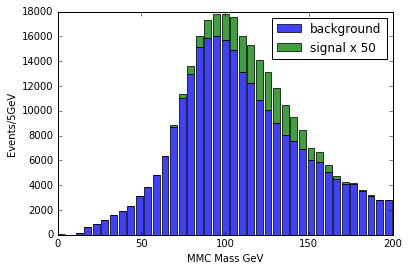

In [4]:
bins = np.linspace(0, 200, 40)
fig = pyplot.figure()
pyplot.hist([bkg,sig], bins, weights=[bkgweights,sigweights], stacked=True, alpha=0.75, label=['background','signal x 50'])
pyplot.legend(loc='upper right')
pyplot.ylabel('Events/5GeV')
pyplot.xlabel('MMC Mass GeV')
pyplot.show()
fig.savefig('MMChist.pdf', bbox_inches='tight')

If we normalise these histograms we can see that the background follows a distinctive [BreitWigner](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution), whilst the signal forms a nice clean Gaussian

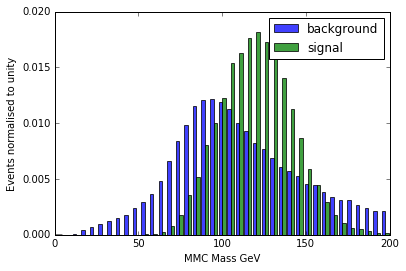

In [5]:
bins = np.linspace(0, 200, 40)
fig = pyplot.figure()
pyplot.hist([bkg,sig], bins, weights=[bkgweights,sigweights], normed=True, alpha=0.75, label=['background','signal'])
pyplot.legend(loc='upper right')
pyplot.ylabel('Events normalised to unity')
pyplot.xlabel('MMC Mass GeV')
pyplot.show()
fig.savefig('MMCpdf.pdf', bbox_inches='tight')

If not normalised to the event weight, there are roughly equal signal and background simulated events. The sum of the event weights forms the number of each classification.

In [6]:
sigsum = sum(sigweights)
bkgsum = sum(bkgweights)
print 'n signal {0}, n background {1}'.format(sigsum,bkgsum)

n signal 34599.4303856, n background 410999.847322


## Creating a workspace

In order to perform statistical tests on this code using the RooStats suite of libraries, first we need to create a workspace. A workspace should contain the statistical model (including any defining parameters such as the normalisations), a pdf of the expected distribution, a parameter of interest (as included in the model), and data to compare this model to.

The first step is to move these distributions from vectors to histograms that can be read by RooFit.

In [7]:
h1 = ROOT.TH1D("h1","signal histogram",40,0,200)
for i in range(len(sig)): h1.Fill(sig[i],sigweights[i])
h2 = ROOT.TH1D("h2","background histogram",40,0,200)
for i in range(len(bkg)): h2.Fill(bkg[i],bkgweights[i])
x = ROOT.RooRealVar("x","x",0,200)
l = ROOT.RooArgList(x)
signalhist = ROOT.RooDataHist("sighist", "sighist", l, h1)
sigpdf = ROOT.RooHistPdf("sigpdf","sigpdf",ROOT.RooArgSet(x),signalhist,0)
bkghist = ROOT.RooDataHist("bkghist", "bkghist", l, h2)
bkgpdf = ROOT.RooHistPdf("bkgpdf","bkgpdf",ROOT.RooArgSet(x),bkghist,0)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(sighist): fit range of variable x expanded to nearest bin boundaries: [0,200] --> [0,200]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(bkghist): fit range of variable x expanded to nearest bin boundaries: [0,200] --> [0,200]


These histograms are now ready to be imported into a workspace.

The parameter x controls the range over which we wish to perform tests on this variable.

In [8]:
w = ROOT.RooWorkspace("w")
w.var("x")
getattr(w,'import')(sigpdf)
getattr(w,'import')(bkgpdf)

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset sighist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::sigpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::x
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset bkghist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::bkgpdf


In this example we define a model as a function of the number of signal and number of background events.

In [9]:
w.factory("SUM:model(n_sig[0.1*n_sig,10*n_sig]*sigpdf, n_bkg[.1*n_bkg,10*n_bkg]*bkgpdf)")
w.var("n_sig").setRange(0.1*sigsum,10*sigsum)
w.var("n_sig").setVal(sigsum)
w.var("n_bkg").setRange(.1*bkgsum,10*bkgsum)
w.var("n_bkg").setVal(bkgsum)

We can also create some pseudo data from this model and retrieve the model from the workspace as:

In [10]:
pdf = w.pdf("model")
x = w.var("x")
x.setBins(40)
data = pdf.generate(ROOT.RooArgSet(x))
data.SetName("data")
getattr(w,'import')(data)
data.Print()

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data
RooDataSet::data[x,weight:weight] = 40 entries (445599 weighted)


Finally we can define the configuration of this workspace in a configuration file:

In [11]:
mc = ROOT.RooStats.ModelConfig("ModelConfig",w)
mc.SetPdf(pdf)
mc.SetParametersOfInterest(ROOT.RooArgSet(w.var("n_sig")))
mc.SetSnapshot(ROOT.RooArgSet(w.var("n_sig")))
mc.SetObservables(ROOT.RooArgSet(w.var("x")))
w.defineSet("nuisParams","n_bkg")
nuis = getattr(w,'set')("nuisParams")
mc.SetNuisanceParameters(nuis)
getattr(w,'import')(mc)

False

and write the workspace to file for playing with later.

In [12]:
w.writeToFile("output/Preselection.root",True)

False

Let's draw this model before we go.

In [13]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Reconstructed Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.SetXTitle("MMC mass (GeV)")
#pdf.plotOn(plot,ROOT.RooFit.Name("model"))
data.plotOn(plot,ROOT.RooFit.Name("data"))
pdf.plotOn(plot,ROOT.RooFit.Name("sigpdf"),ROOT.RooFit.Name("signal"), ROOT.RooFit.LineColor(2), ROOT.RooFit.LineStyle(2), ROOT.RooFit.DrawOption("F"), ROOT.RooFit.FillStyle(3004), ROOT.RooFit.FillColor(2))
pdf.plotOn(plot,ROOT.RooFit.Components("bkgpdf"),ROOT.RooFit.Name("background"), ROOT.RooFit.LineStyle(4), ROOT.RooFit.DrawOption("F"), ROOT.RooFit.FillStyle(3004), ROOT.RooFit.FillColor(4))
l = ROOT.TLegend( 0.6, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
modobj = plot.findObject("model")
zobj = plot.findObject("background")
hobj = plot.findObject("signal")
l.AddEntry( dataobj , "Data", "pl" )
l.AddEntry( zobj , "{0:0.0f} Z#rightarrow#tau#tau events".format(w.var("n_bkg").getVal()), "f"  )
l.AddEntry( hobj , "{0:0.0f} Higgs events".format(w.var("n_sig").getVal()), "f"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkgpdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#0] ERROR:InputArguments -- RooPlot::findObject(frame_x_8d3f850) cannot find object model


Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).


## VBF selection

We can also use the various other variables in the data set to make a selection that enhances processes for better isolating key features of the data. The VBF selection is used here, two jets are requires with an invariant mass of more than 200 GeV and a separation in pseudorapidity of more than 2.

In [14]:
all = list(csv.reader(open(inputfile,"rb"), delimiter=','))
VBF = [variables for variables in all[1:] if (float(variables[6]) > 200 and float(variables[5]) > 2) ]

In [15]:
sig = [float(row[1]) for row in VBF[1:] if row[-1] == 's' ]
sigweights = [float(row[-2])*50 for row in VBF[1:] if row[-1] == 's' ]
bkg = [float(row[1]) for row in VBF[1:] if row[-1] == 'b' ]
bkgweights = [float(row[-2]) for row in VBF[1:] if row[-1] == 'b' ]

sigsum = sum(sigweights)
bkgsum = sum(bkgweights)
print 'n signal {0}, n background {1}'.format(sigsum,bkgsum)

h1 = ROOT.TH1D("h1","signal histogram",20,0,200)
for i in range(len(sig)): h1.Fill(sig[i],sigweights[i])
h2 = ROOT.TH1D("h2","background histogram",20,0,200)
for i in range(len(bkg)): h2.Fill(bkg[i],bkgweights[i])
x = ROOT.RooRealVar("x","x",0,200)
l = ROOT.RooArgList(x)
signalhist = ROOT.RooDataHist("sighist", "sighist", l, h1)
sigpdf = ROOT.RooHistPdf("sigpdf","sigpdf",ROOT.RooArgSet(x),signalhist,0)
bkghist = ROOT.RooDataHist("bkghist", "bkghist", l, h2)
bkgpdf = ROOT.RooHistPdf("bkgpdf","bkgpdf",ROOT.RooArgSet(x),bkghist,0)
w = ROOT.RooWorkspace("w")
getattr(w,'import')(sigpdf)
getattr(w,'import')(bkgpdf)
w.var("x")
w.factory("SUM:model(n_sig[0.1*n_sig,10*n_sig]*sigpdf, n_bkg[.1*n_bkg,10*n_bkg]*bkgpdf)")
w.var("n_sig").setRange(0.1*sigsum,10*sigsum)
w.var("n_sig").setVal(sigsum)
w.var("n_bkg").setRange(.1*bkgsum,10*bkgsum)
w.var("n_bkg").setVal(bkgsum)

pdf = w.pdf("model")
x = w.var("x")
x.setBins(20)
data = pdf.generate(ROOT.RooArgSet(x))
data.SetName("data")
getattr(w,'import')(data)
data.Print()

n signal 2625.68454622, n background 7794.33337887
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(sighist): fit range of variable x expanded to nearest bin boundaries: [0,200] --> [0,200]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(bkghist): fit range of variable x expanded to nearest bin boundaries: [0,200] --> [0,200]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset sighist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::sigpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::x
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset bkghist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::bkgpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data
RooDataSet::data[x,weight:weight] = 20 entries (10420 weighted)


Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


In [16]:
mc = ROOT.RooStats.ModelConfig("ModelConfig",w)
mc.SetPdf(pdf)
mc.SetParametersOfInterest(ROOT.RooArgSet(w.var("n_sig")))
mc.SetSnapshot(ROOT.RooArgSet(w.var("n_sig")))
mc.SetObservables(ROOT.RooArgSet(w.var("x")))
w.defineSet("nuisParams","n_bkg")
nuis = getattr(w,'set')("nuisParams")
mc.SetNuisanceParameters(nuis)
getattr(w,'import')(mc)

False

In [17]:
w.writeToFile("output/VBFselection.root",True)

False

In [18]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Reconstructed Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.SetXTitle("MMC mass (GeV)")
#pdf.plotOn(plot,ROOT.RooFit.Name("model"))
data.plotOn(plot,ROOT.RooFit.Name("data"))
pdf.plotOn(plot,ROOT.RooFit.Name("sigpdf"),ROOT.RooFit.Name("signal"), ROOT.RooFit.LineColor(2), ROOT.RooFit.LineStyle(2), ROOT.RooFit.DrawOption("F"), ROOT.RooFit.FillStyle(3004), ROOT.RooFit.FillColor(2))
pdf.plotOn(plot,ROOT.RooFit.Components("bkgpdf"),ROOT.RooFit.Name("background"), ROOT.RooFit.LineStyle(4), ROOT.RooFit.DrawOption("F"), ROOT.RooFit.FillStyle(3004), ROOT.RooFit.FillColor(4))
l = ROOT.TLegend( 0.6, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
modobj = plot.findObject("model")
zobj = plot.findObject("background")
hobj = plot.findObject("signal")
l.AddEntry( dataobj , "Data VBF", "pl" )
l.AddEntry( zobj , "{0:0.0f} Z#rightarrow#tau#tau events".format(w.var("n_bkg").getVal()), "f"  )
l.AddEntry( hobj , "{0:0.0f} Higgs events".format(w.var("n_sig").getVal()), "f"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkgpdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#0] ERROR:InputArguments -- RooPlot::findObject(frame_x_70f5570) cannot find object model


Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).


## Higgs Enhanced SR

Let's now define a signal region which is just this MMC mass between 100 and 150 GeV

In [19]:
SR = [variables for variables in VBF[1:] if (float(variables[1]) > 100 and float(variables[1]) < 150) ]

In [20]:
sig = [float(row[1]) for row in SR[1:] if row[-1] == 's' ]
sigweights = [float(row[-2])*10 for row in SR[1:] if row[-1] == 's' ]
bkg = [float(row[1]) for row in SR[1:] if row[-1] == 'b' ]
bkgweights = [float(row[-2]) for row in SR[1:] if row[-1] == 'b' ]

sigsum = sum(sigweights)
bkgsum = sum(bkgweights)
print 'n signal {0}, n background {1}'.format(sigsum,bkgsum)

h1 = ROOT.TH1D("h1","signal histogram",5,100,150)
for i in range(len(sig)):     h1.Fill(sig[i],sigweights[i])

h2 = ROOT.TH1D("h2","background histogram",5,100,150)
for i in range(len(bkg)):     h2.Fill(bkg[i],bkgweights[i])
x = ROOT.RooRealVar("x","x",100,150)
l = ROOT.RooArgList(x)
signalhist = ROOT.RooDataHist("sighist", "sighist", l, h1)
sigpdf = ROOT.RooHistPdf("sigpdf","sigpdf",ROOT.RooArgSet(x),signalhist,0)
bkghist = ROOT.RooDataHist("bkghist", "bkghist", l, h2)
bkgpdf = ROOT.RooHistPdf("bkgpdf","bkgpdf",ROOT.RooArgSet(x),bkghist,0)
w = ROOT.RooWorkspace("w")
getattr(w,'import')(sigpdf)
getattr(w,'import')(bkgpdf)
w.var("x")
w.factory("SUM:model(n_sig[0.1*n_sig,10*n_sig]*sigpdf, n_bkg[.1*n_bkg,10*n_bkg]*bkgpdf)")
w.var("n_sig").setRange(0.1*sigsum,10*sigsum)
w.var("n_sig").setVal(sigsum)
w.var("n_bkg").setRange(.1*bkgsum,10*bkgsum)
w.var("n_bkg").setVal(bkgsum)
pdf = w.pdf("model")
x = w.var("x")
x.setBins(5)
data = pdf.generate(ROOT.RooArgSet(x))
data.SetName("data")
getattr(w,'import')(data)

False

n signal 421.876963784, n background 1819.96369349
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(sighist): fit range of variable x expanded to nearest bin boundaries: [100,150] --> [100,150]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(bkghist): fit range of variable x expanded to nearest bin boundaries: [100,150] --> [100,150]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset sighist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::sigpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::x
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset bkghist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::bkgpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data


Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


In [21]:
mc = ROOT.RooStats.ModelConfig("ModelConfig",w)
mc.SetPdf(pdf)
mc.SetParametersOfInterest(ROOT.RooArgSet(w.var("n_sig")))
mc.SetSnapshot(ROOT.RooArgSet(w.var("n_sig")))
mc.SetObservables(ROOT.RooArgSet(w.var("x")))
w.defineSet("nuisParams","n_bkg")
nuis = getattr(w,'set')("nuisParams")
mc.SetNuisanceParameters(nuis)
getattr(w,'import')(mc)

False

In [22]:
w.writeToFile("output/SRselection.root",True)

False

In [23]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Reconstructed Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.SetXTitle("MMC mass (GeV)")
#pdf.plotOn(plot,ROOT.RooFit.Name("model"))
data.plotOn(plot,ROOT.RooFit.Name("data"))
pdf.plotOn(plot,ROOT.RooFit.Name("sigpdf"),ROOT.RooFit.Name("signal"), ROOT.RooFit.LineColor(2), ROOT.RooFit.LineStyle(2), ROOT.RooFit.DrawOption("F"), ROOT.RooFit.FillStyle(3004), ROOT.RooFit.FillColor(2))
pdf.plotOn(plot,ROOT.RooFit.Components("bkgpdf"),ROOT.RooFit.Name("background"), ROOT.RooFit.LineStyle(4), ROOT.RooFit.DrawOption("F"), ROOT.RooFit.FillStyle(3004), ROOT.RooFit.FillColor(4))
l = ROOT.TLegend( 0.6, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
zobj = plot.findObject("background")
hobj = plot.findObject("signal")
l.AddEntry( dataobj , "Data VBF", "pl" )
l.AddEntry( zobj , "{0:0.0f} Z#rightarrow#tau#tau events".format(w.var("n_bkg").getVal()), "f"  )
l.AddEntry( hobj , "{0:0.0f} Higgs events".format(w.var("n_sig").getVal()), "f"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkgpdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).


## Poisson Counting Models
We create now a counting model based on Poisson Statistics. Let's suppose we observe nobs events when we expect nexp, where nexp = s+b (s is the number of signal events and b is the number of background events. The expected distribution for nexp is a Poisson : Poisson( nobs | s+b). s is the parameter we want to estimate or set a limit (the parameter of interest), while b is the nuisance parameter. b is not known exactly, but has uncertainty sigmab. The nominal value of b is = b0=. To express this uncertainty we add in the model a Gaussian constraint. We can interpret this term as having an additional measurement b0 with an uncertainty sigmab: i.e. we have a likelihood for that measurement =Gaussian( b0 | b, sigma). In case of Bayesian statistics we can interpret the constraint as a prior knowledge on the parameter b.

* Make first the RooFit workspace using its factory syntax. Let's assume nobs=3, b0=1, sigmab=0.2.
* Create the ModelConfig object and import in the workspace. We need to add in the ModelConfig also b0 as a "global observable". The reason is that b0 needs to be treated as an auxiliary observable in case of frequentist statistics and varied when tossing pseudo-experiments. 
here we define nobs as the number of observed events, b as the number of background events, sigmab is the relative uncertainty in number of background events.

In this example, nobs is the number of 'data' events in the signal region in the 125 GeV bin. The same goes for the number of background events and the error on these. 

In [24]:
mH_Bin = [variables for variables in SR[1:] if (float(variables[1]) > 120 and float(variables[1]) < 130) ]

In [25]:
sigweights = [float(row[-2])*10 for row in mH_Bin[1:] if row[-1] == 's' ]
bkgweights = [float(row[-2]) for row in mH_Bin[1:] if row[-1] == 'b' ]

sigsum = sum(sigweights)
bkgsum = sum(bkgweights)
totalsum = sigsum+bkgsum

In [26]:
nobs = totalsum
b = bkgsum
sigmab = .2

Now we can define a new poisson model with a Gaussian constraint. The Poisson is (n | s+b)

In [27]:
w = ROOT.RooWorkspace("w")
w.factory("sum:nexp(s[126,0,500],b[300,0,1000])")
w.factory("Poisson:pdf(nobs[0,1000],nexp)")
w.factory("Gaussian:constraint(b0[0,1000],b,sigmab[300])")
w.factory("PROD:model(pdf,constraint)")

<ROOT.RooProdPdf object ("model") at 0xdde2dd0>

In [28]:
w.var("b0").setVal(b)
w.var("b0").setConstant(True)
w.var("sigmab").setVal(sigmab*b) 

We create the model config, and make sure we make a snapshot

In [29]:
mc = ROOT.RooStats.ModelConfig("ModelConfig",w)
mc.SetPdf(w.pdf("model"))
mc.SetParametersOfInterest(ROOT.RooArgSet(w.var("s")))
mc.SetObservables(ROOT.RooArgSet(w.var("nobs")))
mc.SetNuisanceParameters(ROOT.RooArgSet(w.var("b")))

mc.SetSnapshot(ROOT.RooArgSet(w.var("s")))
mc.SetGlobalObservables(ROOT.RooArgSet(w.var("b0")))

mc.Print()
getattr(w,'import')(mc)

False


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (nobs)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (b)
Global Observables:      RooArgSet:: = (b0)
PDF:                     RooProdPdf::model[ pdf * constraint ] = 4.06229e-05
Snapshot:                
  1) 0xdbbaad0 RooRealVar:: s = 126  L(0 - 500)  "s"



make data set with the namber of observed events

In [30]:
data = ROOT.RooDataSet("data","", ROOT.RooArgSet(w.var("nobs")))
w.var("nobs").setVal(426)
data.add(ROOT.RooArgSet(w.var("nobs") ))

getattr(w,'import')(data)

w.Print()

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data

RooWorkspace(w) w contents

variables
---------
(b,b0,nobs,s,sigmab)

p.d.f.s
-------
RooGaussian::constraint[ x=b0 mean=b sigma=sigmab ] = 0.999606
RooProdPdf::model[ pdf * constraint ] = 0.0193174
RooPoisson::pdf[ x=nobs mean=nexp ] = 0.019325

functions
--------
RooAddition::nexp[ s + b ] = 426

datasets
--------
RooDataSet::data(nobs)

parameter snapshots
-------------------
ModelConfig__snapshot = (s=126)

named sets
----------
ModelConfig_GlobalObservables:(b0)
ModelConfig_NuisParams:(b)
ModelConfig_Observables:(nobs)
ModelConfig_POI:(s)
ModelConfig__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



And write to file!

In [31]:
w.writeToFile("output/mH_BinModel.root", True)

False